***

# Event Lip Reading

**Author**: Adly Zaroui

The "Event Lip Reading" project aims to develop a system that can recognize and interpret lip movements from event-based sensor data. Event-based sensors are capable of capturing high-frequency changes in luminosity, making them ideal for applications that require a high refresh rate. In this project, the event data consists of tuples containing the pixel coordinates, polarity (increase or decrease in luminosity), and timestamp of each event.

The goal of the project is to classify these events and extract meaningful information from them. This can be achieved by aggregating the events into superframes, converting them into images, and applying various image processing techniques. The project involves tasks such as loading the event data, converting events to images, creating animations from the images, and aggregating events into superframes.

By analyzing the lip movements captured by the event-based sensor, the system can potentially be used for lip reading applications, speech recognition, and other related tasks. The project utilizes Python, pandas, numpy, matplotlib, and other libraries to process and visualize the event data.

To analyze event data, there is mainly 2 ways: the first one is to convert the events into conventional video data (sequence of images - sequence of matrices of pixels values) then apply conventional video classification algorithms. The first path that we will dive into is to treat event data as they are: multivariate time series, then explore classification techniques on mulitvariate time series.

***

First, let's define a function that loads the data and then use it to load he data:

In [ ]:
from utils import load_data

# Define the base paths
train_base_path = 'train10/train10/'
test_base_path = '/test10/test10/'

# Define the class folders
class_folders = ['Addition', 'Carnaval', 'Decider', 'Ecole', 'Fillette', 'Huitre', 'Joyeux', 'Musique', 'Pyjama', 'Ruisseau']

# Load the training and test data
x_train = load_data(train_base_path, class_folders)
#x_test = load_data(test_base_path)

# Create target data
y_train = [i for i in range(10) for _ in range(32)]

## Visualization

***
Now let's plot an image from an event dataframe:

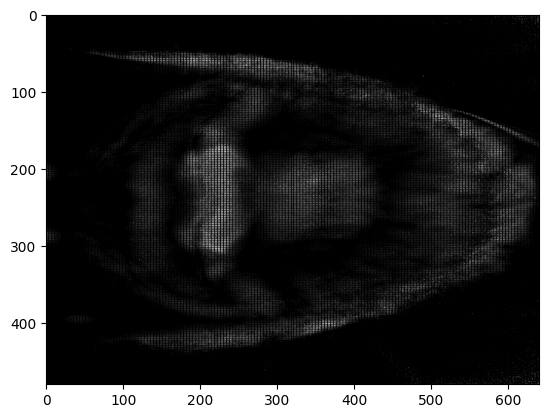

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import events_to_image

column_names = ['x', 'y', 'p', 't']
test_event_df = pd.read_csv('train10/train10/Addition/0.csv', header=None, names=column_names) # Load the first file as a sample

test_images = events_to_image(test_event_df) # Convert the events to an image 

# Display an example image
plt.imshow(test_images, cmap='gray')
plt.show()

***
Now let's define some functions convert an event dataframe into a sequence of images, incrisignly *w.r.t.* timestamp

In [2]:
''' Define the superframes '''

from utils import decompose_events, event_agg_polarity
import pandas as pd

column_names = ['x', 'y', 'p', 't']
test_event_df = pd.read_csv('train10/train10/Addition/0.csv', header=None, names=column_names) # Load the first file as a sample

x, y, p, t = decompose_events(test_event_df)

negative_superframes, positive_superframes = event_agg_polarity(x, y, p, t)


100%|██████████| 30/30 [00:00<00:00, 338.79it/s]


generated superframes with size: (30, 640, 480) and (30, 640, 480)


In [3]:
''' Watch the superframes '''
    
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML, display
    
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(negative_superframes.shape[0]):
    frames.append([plt.imshow(negative_superframes[i], cmap = cm.Greys_r, animated = True)])

ani = animation.ArtistAnimation(fig, frames, interval = 50, blit = False, repeat_delay = 1000)
plt.close(fig)  # close the figure

# center the animation
display(HTML(ani.to_jshtml()), metadata=dict(horizontal_center=True))

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML, display

fig, ax = plt.subplots(figsize=(6, 4))  # Create a single subplot

# Remove the margins on the x and y axes
ax.margins(x=0, y=0)

# Assuming superframes[0] and superframes[1] are your two sets of frames for the animations
img1 = ax.imshow(negative_superframes[0], cmap = cm.Greys_r, vmin=-1, vmax=0, animated = True, label='negative_superframes')
img2 = ax.imshow(positive_superframes[0], cmap = cm.Blues, vmin=0, vmax=1, animated = True, label='positive_superframes')

def update(i):
    
    '''
    
    Update the image for iteration `i` 
    
    parameters:
        i (int): The iteration number.
    
    returns:
        img1 (matplotlib.image.AxesImage): The updated image.
        img2 (matplotlib.image.AxesImage): The updated image.
        
    '''
    img1.set_array(negative_superframes[i])
    img2.set_array(positive_superframes[i])
    return img1, img2

ani = animation.FuncAnimation(fig, update, frames=range(min(len(negative_superframes), len(positive_superframes))), blit=False, repeat_delay=1000)

# Add title and labels
ax.set_title('\'Addition\' utterance')

# Add legend
ax.legend()

# Add caption
fig.text(0.5, 0.01, 'This animation is derived from an event DataFrame that has been transformed into a standard video format.', ha='center', fontsize=7.5)

plt.close(fig)  # close the figure

# center the animation
display(HTML(ani.to_jshtml()), metadata=dict(horizontal_center=True))

# save the animation as a gif
#ani.save('figures/readme_animation.gif', writer='imagemagick', fps=60)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MovieWriter imagemagick unavailable; using Pillow instead.


***
## PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

window_size = 5 # window size for smoothing
# Denoise and compute statistics for each DataFrame
flat_agg_x_train = []
for event_df in x_train:
    event_df_smooth = event_df.rolling(window_size).mean().dropna()

    stats = event_df_smooth.agg(['mean', 'std', 'max', 'min', 'skew', 'kurt', 'median', 'sem'])
    flat_agg_x_train.append(stats.values.flatten())
        
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(flat_agg_x_train)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca_x_train = pca.fit_transform(x_train_scaled)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Create a scatter plot of the first two principal components
scatter = plt.scatter(pca_x_train[:, 0], pca_x_train[:, 1], c=y_train, cmap=cm.Set1)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Classes')

# Add a title and labels
plt.title('PCA of x_train')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Show the plot
plt.show()

In [ ]:
pca.n_components_